# Simple NN Recurrent Neural Network

## The idea

We have a certain phenomena that we want to model/predict with data, but we don't see much of a pattern from one day to the next. For example, a stock exchange where the stock is relatively volatile from day to day, but in the long run we see a clear pattern.

For this it would clearly be useful to input a number of data points from earlier times. In our stock example this would mean inputting the stock from the last 5 trading days rather than just the last one.

From our previous efforts, we know that we could plug those inputs into a neural network, train it and look at what comes out. But neural networks are not magic or infallible, and can soemtimes train towards the wrong patterns, or take a very long time to train a relatively good model. We know instictively that not all of these data points are equal; the days closer to the date we want to predict will be more indicative of what the value may be. So we want to make it easy for the network and set it up so that it prioritises these values intuitively and doesn't have to work out that they're useful.

From our previous efforts with very simple networks, we know that we could do this by creating a neural net with 5 inputs and initialising the weights so that the later dates have a higher impact (so that gradient descent finds the local minima around there) . This has a few disadvantages, for one, the static structure of the network would always require the same number of inputs to work. so if we had stock data for 5 days in one case and 10 for another, then we would not be able to train the network properly on the first case (as we didn't have enough days of data) and we would be unable to use all of the available information in the second case.
it would also be very hard to manage initial weighting with more complex neural networks with lots of layers and nodes, where the later layers can become organised in a way that is very hard for humans to understand. 

Instead, we'll introduce another approach which avoids these problems, a recurrent neural network (RNN). It's not as scary as it sounds, and not as complicated either. It essentially runs each day's input through a neural network, and then adds it as an input to the next one with a scaling weight (that we look to optimise.)


## The Network Architecture



Your typical graph of an RNN will look like this:

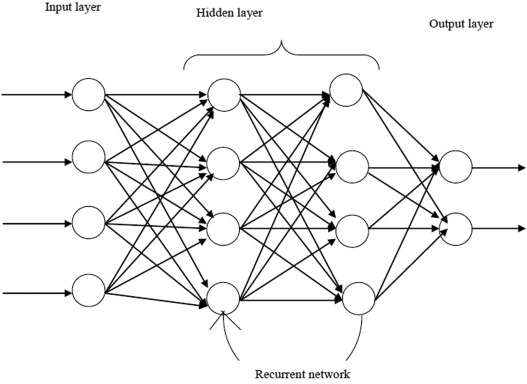 

credit: Balachandra Kumaraswamy, in Artificial Intelligence in Data Mining, 2021, chap 6.2.5

This looks scary, so I'll give you a simpler version of the same thing:

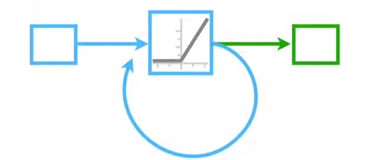

You can See how the arrow that circles back around the activation function represents the recurring action of the network. To me, this still isn't immediately intuitive, so I prefer to use this trick from Josh Starmer at StatQuest (youtube) where we unroll the network to get the following:

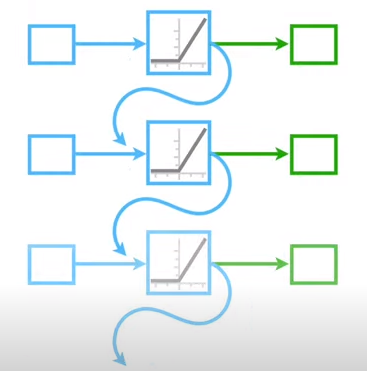

Now this makes a bit more sense. We'll go through the steps for this picture.

1) We run input 1 through a mini neural net ("mini net 1") (where input 1 is the one furthest back in time \[or the one assumed least important for our model\])
2) We save the output from input 1 and also pass down the output from the hidden layer to our next mini net (mini net 2)
3) We run input 2 through mini net 2. Mini net 2 will take the output from mini net 1 into account and then save it's own output and also pass it down to mini net 3.
4) this process is continued until we get a final output which takes all of the inputs into account.

In practice, we will store an array of the outputs at each time step which can be used for backpropagation, model evaluation and evasion of the vanishing gradient problem (which we will cover later).

We use the same weight to transfer between each mini net and to the next. This is because we assume "temporal conistency" in the network - i.e. that any given input will be effected in the same way by each input before (dependent on distance in time steps) and each input after (also dependent on distance in time steps) as any other given input. 

A final note is that in practice, we refer to mini nets as "cells" in the network. These cells are the repeating units in the network

(Pictures from StatQuest, youtube, Recurrent Neural Networks (RNNs) Clearly Explained!!!: https://www.youtube.com/watch?v=AsNTP8Kwu80)

### Note: standard graphical representation

Rather than the "left to right" graphs that we have made so far, for networks with recurrence we use a vertical graphing style, with the inputs at the bottom and the outputs at the top.

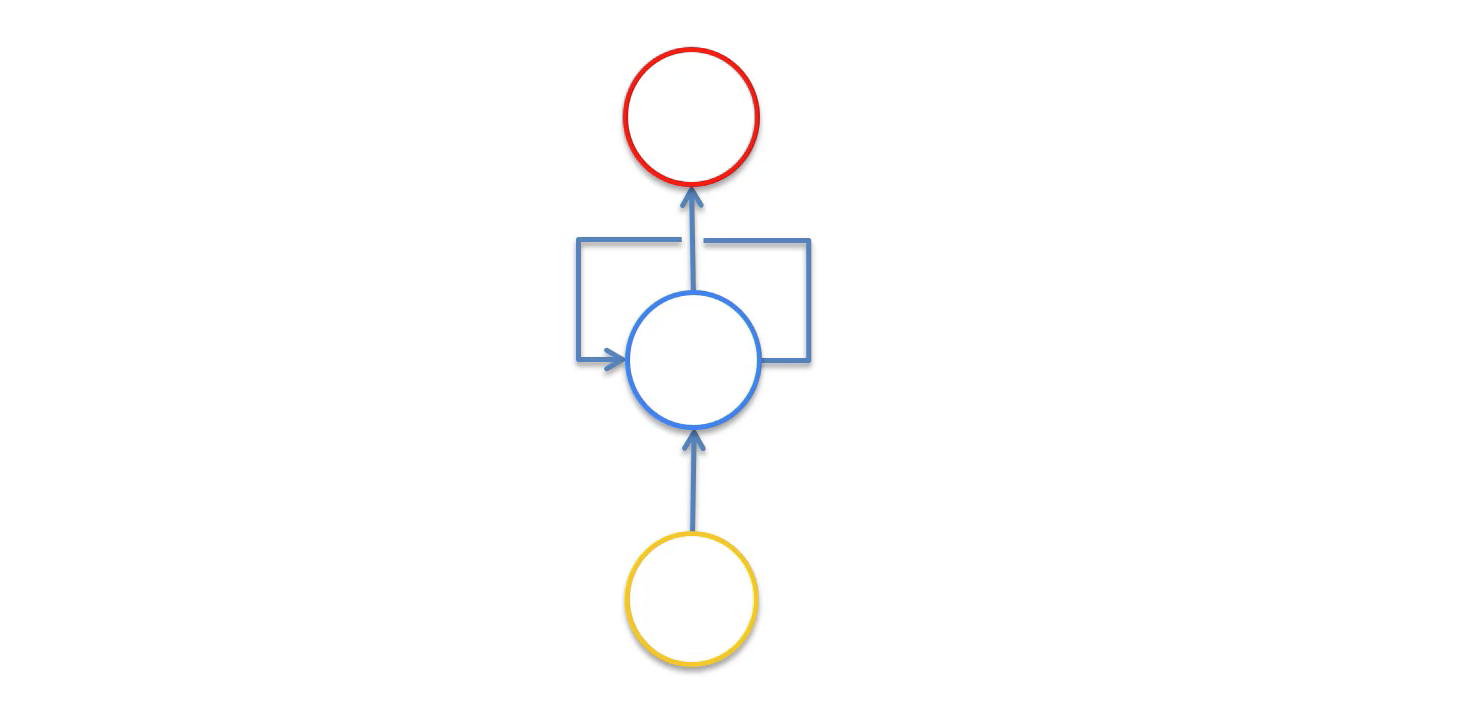

credit: https://www.freecodecamp.org/news/the-ultimate-guide-to-recurrent-neural-networks-in-python/

This graph is basically a rotated version of our first Statquest recursion graph. We have the input in yellow, the recurrent cells in blue, and the output in red. This is essentially the representation of a general RNN, the blue circle can be as big of a layer as we want. If you feel that you would like more convincing of this, there is a good explanation in the article by freecodecamp.org here:  https://www.freecodecamp.org/news/the-ultimate-guide-to-recurrent-neural-networks-in-python/


## Backpropagation in RNNs: Backpropagation through time (BTT)

Now that we know how the network manages it's forward pass, let's have a look at how we can backpropagate to train the network.

The main difference between this network architecture and our basic feed-forward model is that we have weights that are applied multiple times in the same process. The weight we highlighted above was the weight between cells, but the weights inside each cell are shared across all cells too.

For us this means two things:

1) relative to a Feed Forward Neural Net with the same number of nodes, we have fewer weights/gradients to work with. 
2) the gradients of the weights will be more complicated than we have previously seen.

So we'll have to see how this is going to affect our approach.

Let's consider this RNN:

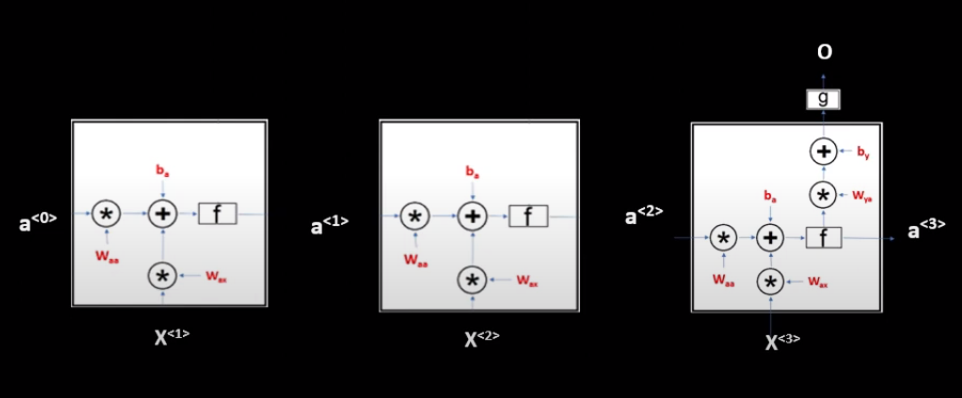

credit: https://www.youtube.com/watch?v=Wu9BsMSKqyk

As you may notice, this is slightly different to our example above. the network starts with an inital "previous value" $a^{<0>}$ which we will set to $0$, and the only the final cell has an output - this means it has an additional weight $w_{ya}$ and bias $b_y$ in the mini net.

As you can see, there are only 5 distinct weights and biases,  $w_{ya}$, $w_{aa}$, $w_{xa}$,  $b_y$, $b_a$. So we'll work out the gradients associated with each of these manually.

We also have two activation functions <b> f </b> and <b> g </b>. We'll leave these as unspecified functions for now, but we can see that the $a^{<i>}$'s and $O$ (our output) are dependent on these functions and the weights in each cell. Explicitly:

$a^{<i>} = f(w_{aa} * a^{<i-1>} + X^{<i>} * w_{ax} + b_a) $ and $O = g(w_{ya}* a^{<3>} + b_y)$



We will define our loss function to be the SSR (Sum of Squared Residuals) function that we used in our first backpropagation notebook.

$$
SSR(x) = \sum_1^n ( y_{observed} - y_{pred})^2
$$

where $x$ is the input (vector) to our network, $y_{pred}$ is the output of our network and $y_{observed}$ is the true value associated with the output x. Clearly this requires us to know the true value associated with $x$, so we can only use this function for training our network with results that we know.

$w_{ya}$ and $b_y$ are the simplest to calculate, as they each only appear once.

From the ideas of the previous notebook on AutoGrad backward differentiation, we have with the multiplication rule, that the gradient of $w_{ya}$, $\frac{\delta L}{\delta w_{ya}}$ is 

$\frac{\delta SSR}{\delta w_{ya}} = \frac{\delta SSR}{\delta O} * \frac{\delta O}{\delta b_y} * \frac{\delta b_y}{\delta w_{ya}}$

from out previous notebook, we know that biases will affect the rate of change (partial derivative) of the next step in a very simple way. i.e.  $\frac{\delta O}{\delta b_y}  = 1$ 

On top of this, we know by the multiplication rule that:  $\frac{\delta b_y}{\delta w} = a^{<3>} $

And thirdly, the derivate of $SSR$ with respect to the predicted values is $\sum_1^n-2(y_{observed} - y_{pred})$

$\frac{\delta L}{\delta w_{ya}} = a^{<3>} $

so finally we get:

$$\frac{\delta L}{\delta w_{ya}} = \sum_1^n-2 a^{<3>}  (y_{observed} - y_{pred}) $$

For $b_y$, we have from the linear nature of the bias' effect on the output, that the $\frac{\delta O}{\delta b_y} = 1$, so

$$
\frac{\delta SSR}{\delta b_y} = \frac{\delta SSR}{\delta O} * \frac{\delta O}{\delta b_y} = \frac{\delta SSR}{\delta O} = \sum_1^n-2(y_{observed} - y_{pred})
$$

### More complex gradients
Now we're going to look at the gradients $\frac{\delta L}{\delta w_{aa}}$ and $\frac{\delta L}{\delta w_{aa}}$. Each of these takes components from all three of the cells so we need to be careful with how we take that into account.

We're going to look at $w_{aa}$ first. What we're going to do is split the flow of "information" into 3 paths, and then apply the chain rule to each of the paths:

Path 1: SSR -> Output (O) -> $a^{<3>}$ -> $w_{aa}$

Path 2: SSR -> Output (O) -> $a^{<3>}$ -> $a^{<2>}$ -> $w_{aa}$

Path 3: SSR -> Output (O) -> $a^{<3>}$ -> $a^{<2>}$ -> $a^{<1>}$ -> $w_{aa}$

Each of these chains focuses on one of the instances of $w_{aa}$, Path 1 does cell 3, Path 2 cell 2 and Path 3 cell 1. You may think that these would interfere, this is true when we run the network, but for the gradients they actually separate out quite nicely. 

To show this, we'll take a look at the derivative down Path 1: We're going to look at this  


Note: for path 1, don't be put off by the location of $a^{<3>}$ in the diagram: we're looking at the box labelled <b> f </b> which holds the value of $a^{<i>}$ in the $i^{th}$ cell



Now if we apply the chain rule to each of these paths, we get:

Path 1: $\frac{\delta SSR}{\delta w_{aa}^1} = \frac{\delta SSR}{\delta O} * \frac{\delta O}{\delta a^{<3>}} * \frac{\delta a^{<3>}}{\delta w_{aa}}$

Path 2: $\frac{\delta SSR}{\delta w_{aa}^2} = \frac{\delta SSR}{\delta O} * \frac{\delta O}{\delta a^{<3>}} * \frac{\delta a^{<3>}}{\delta a^{<2>}} * \frac{\delta a^{<2>}}{\delta w_{aa}}$

Path 3: $\frac{\delta SSR}{\delta w_{aa}^3} = \frac{\delta SSR}{\delta O} * \frac{\delta O}{\delta a^{<3>}} * \frac{\delta a^{<3>}}{\delta a^{<2>}}* \frac{\delta a^{<2>}}{\delta a^{<1>}} * \frac{\delta a^{<1>}}{\delta w_{aa}}$

now as they are essentially 3 independent cases for how the derivative changes, we need to add them together to get the final value, which comes out to be:

$$\frac{\delta SSR}{\delta w_{aa}} = \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<3>}}  \frac{\delta a^{<3>}}{\delta w_{aa}} + \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<3>}}  \frac{\delta a^{<3>}}{\delta a^{<2>}}  \frac{\delta a^{<2>}}{\delta w_{aa}} + \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<3>}}  \frac{\delta a^{<3>}}{\delta a^{<2>}} \frac{\delta a^{<2>}}{\delta a^{<1>}}  \frac{\delta a^{<1>}}{\delta w_{aa}}$$

which (as $\frac{\delta O}{\delta a^{<3>}}  \frac{\delta a^{<3>}}{\delta a^{<2>}} \frac{\delta a^{<2>}}{\delta a^{<1>}} = \frac{\delta O}{\delta a^{<1>}}$) is equal to:

$$
\frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<3>}}  \frac{\delta a^{<3>}}{\delta w_{aa}} + \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<2>}}  \frac{\delta a^{<2>}}{\delta w_{aa}} + \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<1>}}  \frac{\delta a^{<1>}}{\delta w_{aa}}
$$

or in a more compact form: 

$$
\frac{\delta SSR}{\delta w_{aa}} = \sum_1^n \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<i>}}  \frac{\delta a^{<i>}}{\delta w_{aa}}
$$

This is actually really useful for us. Notice that this formula could be applied to the network for any number of cells, which means that we don't need to recalculate a closed form
for the gradient when we add or remove cells, so we don't need to use methods like the computation graphs we used for FFNNs for this particular weight. Ideally we would be able to find closed forms for the other weights so lets do that now.

Now we need to calculate the terms in the sum:
from before:

$$
\frac{\delta SSR}{\delta O} = \sum_1^n-2(y_{observed} - y_{pred})
$$

and from the formula of $a^{<i>}$: 

$$
\frac{\delta a^{<i>}}{\delta w_{aa}} = \frac{\delta f(w_{aa} * a^{<i-1>} + w_{ax} * X^{<i>}  + b_a)}{\delta w_{aa}} 
$$

now, the $ w_{ax} * X^{<i>}$ term does not depend on $w_{ax}$ so it's partial derivative is zero. but both $w_{aa}$ and $a^{<i-1>}$ depend on $w_{aa}$ (because of the recurrence of $w_{aa}$ so when we use the product rule, we get two terms: 

$$
\frac{\delta f(w_{aa} * a^{<i-1>} + w_{ax} * X^{<i>}  + b_a)}{\delta w_{aa}} =  (a^{<i-1>} + w_{aa}\frac{\delta a^{<i-1>}}{w_{aa}} ) f^{\prime}(w_{aa} * a^{<i-1>} + w_{ax} * X^{<i>}  + b_a)
$$

Now this gives us another partial derivative to solve: $\frac{\delta a^{<i-1>}}{w_{aa}} $ which is in fact the same derivative as we started with, just in the previous cell, as the cells are essentially identical, we get 

$$
\frac{\delta a^{<i-1>}}{w_{aa}}  = (a^{<i-2>} + w_{aa}\frac{\delta a^{<i-2>}}{w_{aa}} ) f^{\prime}(w_{aa} * a^{<i-2>} + w_{ax} * X^{<i-1>}  + b_a)
$$

and then

$$
\frac{\delta a^{<i-2>}}{w_{aa}}  = (a^{<i-3>} + w_{aa}\frac{\delta a^{<i-3>}}{w_{aa}} ) f^{\prime}(w_{aa} * a^{<i-3>} + w_{ax} * X^{<i-2>}  + b_a)
$$

this eventually reaches the step $k$ where $a^{<i-k>} = a^{<1>}$ and then this resolves to $\frac{\delta a^{<1>}}{w_{aa}}  = (a^{<0>} + w_{aa}\frac{\delta a^{<0>}}{w_{aa}} ) f^{\prime}(w_{aa} * a^{<0>} + w_{ax} * X^{<i-k>}  + b_a)$ and if we set $a^{<0>} = 0$ then we get $\frac{\delta a^{<1>}}{w_{aa}}  = 0$

This means that we can essentially solve the system with a recursive algorithm that will find all of the partial derivatives by making its way down the chain and then back up again.

lastly: the steps between $O $ and $ a^{<3>}$ are just the final two weight and the final bias: so it will change in proprtion to the final weight $w_{ya}$ therefore:
$$
\frac{\delta O}{\delta a^{<3>}} = w_{ya}
$$
going back one more cell: the steps between $O $and$ a^{<2>}$ are

We're going to use 3 very similar paths to work with $w_{ax}$:

Path 1: SSR -> Output (O) -> $a^{<3>}$ -> $w_{ax}$

Path 2: SSR -> Output (O) -> $a^{<3>}$ -> $a^{<2>}$ -> $w_{ax}$

Path 3: SSR -> Output (O) -> $a^{<3>}$ -> $a^{<2>}$ -> $a^{<1>}$ -> $w_{ax}$

Now if we repeat the same steps as with $w_{aa}$, then we get a to a very similar result:

$$
\frac{\delta SSR}{\delta w_{ax}} = \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<3>}}  \frac{\delta a^{<3>}}{\delta w_{ax}} + \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<2>}}  \frac{\delta a^{<2>}}{\delta w_{ax}} + \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<1>}}  \frac{\delta a^{<1>}}{\delta w_{ax}}
$$

and with closed form: 

$$
\frac{\delta SSR}{\delta w_{ax}} = \sum_1^n \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<i>}}  \frac{\delta a^{<i>}}{\delta w_{ax}}
$$

from before, we know what $\frac{\delta SSR}{\delta O}$ is. we also have (from our formula for $a^{<i>}$) that $\frac{\delta a^{<i>}}{\delta w_{ax}} = \frac{\delta f(w_{aa} * a^{<i-1>} + w_{ax} * X^{<i>} + b_a)}{\delta w_{ax}} = f^{\prime}(X^{<i>})$

then finally, $\frac{\delta O}{\delta a^{<i>}} = $

which is exactly the kind of thing we wanted.

Now finally for $b_a$, we use paths again. I'll save the details and get to the meat of it:

$$
\frac{\delta SSR}{\delta b_a} = \sum_1^n \frac{\delta SSR}{\delta O}  \frac{\delta O}{\delta a^{<i>}}  \frac{\delta a^{<i>}}{\delta b_a}
$$



## An implementation

In [3]:
hs = {}
print(type(hs))

<class 'dict'>


### The vanishing gradient problem

One of the biggest problems with classical RNNs is dubbed the vanishing gradient problem. This is when 

credit: https://www.freecodecamp.org/news/the-ultimate-guide-to-recurrent-neural-networks-in-python/

This was the best video that I found on Backpropagation Through Time: https://www.youtube.com/watch?v=Wu9BsMSKqyk